<a href="https://colab.research.google.com/github/Hacxmr/log-analysis/blob/main/CIC_IDS_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q imblearn xgboost pydot graphviz

In [3]:
import pandas as pd
import os
import gc

# Convert CSVs to a single Parquet file (ONE-TIME)
path = "datasets/"
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]

df_list = []
for file in files:
    print(f"Reading {file}")
    temp_df = pd.read_csv(file, low_memory=False)
    df_list.append(temp_df)
    del temp_df
    gc.collect()

df = pd.concat(df_list, ignore_index=True)
del df_list
gc.collect()

# Save to Parquet
df.to_parquet("CIC_IDS_2017.parquet", engine='pyarrow')
print("Saved as Parquet successfully!")


Reading datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv
Reading datasets/Tuesday-WorkingHours.pcap_ISCX.csv
Reading datasets/Monday-WorkingHours.pcap_ISCX.csv
Reading datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading datasets/Wednesday-workingHours.pcap_ISCX.csv
Saved as Parquet successfully!


In [3]:
import pandas as pd

# Load directly from Parquet (MUCH faster and memory optimized)
df = pd.read_parquet("CIC_IDS_2017.parquet", engine='pyarrow')
print("Data loaded from Parquet. Shape:", df.shape)


Data loaded from Parquet. Shape: (2830743, 79)


Loading dataset from Parquet...
Original shape: (2830743, 79)
After cleaning: (2520798, 79)
Computing mutual information on sampled data...
Mutual information computed in 69.82 seconds
Applying SMOTE...
SMOTE complete. Class distribution: [1676045 1676045]
Epoch 1/20
6548/6548 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9614 - loss: 0.0992 - precision: 0.9645 - recall: 0.9563 - val_accuracy: 0.9950 - val_loss: 0.0177 - val_precision: 0.9974 - val_recall: 0.9965
Epoch 2/20
6548/6548 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9909 - loss: 0.0263 - precision: 0.9892 - recall: 0.9925 - val_accuracy: 0.9960 - val_loss: 0.0146 - val_precision: 0.9978 - val_recall: 0.9974
Epoch 3/20
6548/6548 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9921 - loss: 0.0216 - precision: 0.9907 - recall: 0.9936 - val_accuracy: 0.9966 - val_loss: 0.0121 - val_precision: 0.9978 - val_recall: 0.9981
Epoch 4/20
6548/6548 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9924 - loss: 0.0201 - precision: 0.

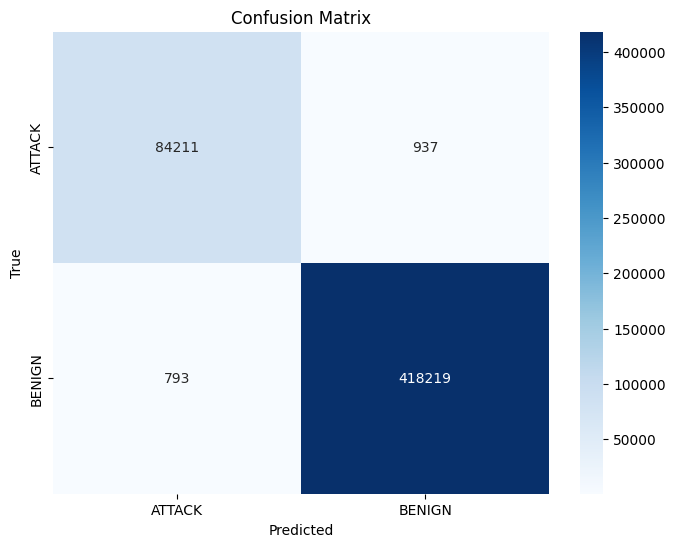

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, gc, os
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping

# Step 1: Load and clean the dataset
print("Loading dataset from Parquet...")
df = pd.read_parquet("CIC_IDS_2017.parquet", engine="pyarrow")
print(f"Original shape: {df.shape}")

# Step 2: Basic cleaning
df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f"After cleaning: {df.shape}")

# Step 3: Binary label mapping
df['Label'] = df['Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')

# Step 4: Feature and label separation
X = df.drop('Label', axis=1)
y = df['Label']

# Select only numeric features and drop constant columns
X = X.select_dtypes(include=[np.number])
X = X.loc[:, X.nunique() > 1]

# Encode labels as a Pandas Series with same index
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y), index=X.index)

# Step 5: Mutual Information on sampled subset
sample_frac = 0.05 if len(X) > 500_000 else 0.2
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y_encoded.loc[X_sample.index]

print("Computing mutual information on sampled data...")
start_time = time.time()
mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42)
mi_series = pd.Series(mi_scores, index=X_sample.columns).sort_values(ascending=False)
print(f"Mutual information computed in {time.time() - start_time:.2f} seconds")

# Step 6: Feature selection
top_k = 30
X = X[mi_series.head(top_k).index]

# Step 7: Scale features and train-test split
scaler = QuantileTransformer(output_distribution='normal', n_quantiles=1000, subsample=100000)
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 8: Balance with SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("SMOTE complete. Class distribution:", np.bincount(y_train))

# Step 9: Define deep learning model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Step 10: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# Step 11: Evaluate
print("\nEvaluating model on test data...")
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
